In [1]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv
from tqdm import tqdm
import time
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
API_KEY = os.getenv("TMDB_API_KEY")

BASE_URL = "https://api.themoviedb.org/3"

In [2]:
def get_movies_from_page(page):
    """Fetch one page of movie results."""
    url = f"{BASE_URL}/discover/movie"
    params = {
        "api_key": API_KEY,
        "sort_by": "vote_count.desc",
        "page": page,
        "include_adult": False
    }
    return requests.get(url, params=params).json()

def get_movie_details(movie_id):
    """Fetch metadata for a movie."""
    url = f"{BASE_URL}/movie/{movie_id}"
    params = {"api_key": API_KEY}
    return requests.get(url, params=params).json()

def get_movie_credits(movie_id):
    """Fetch cast/crew info."""
    url = f"{BASE_URL}/movie/{movie_id}/credits"
    params = {"api_key": API_KEY}
    return requests.get(url, params=params).json()

In [3]:
movies = []
PAGES_TO_SCRAPE = 10   # change to 15–20 if you want ~400–600 movies

for page in tqdm(range(1, PAGES_TO_SCRAPE + 1)):
    page_data = get_movies_from_page(page)
    if "results" not in page_data:
        continue
    
    for movie in page_data["results"]:
        movie_id = movie["id"]

        # Fetch additional metadata
        details = get_movie_details(movie_id)
        credits = get_movie_credits(movie_id)
        time.sleep(0.2)  # prevent rate limits

        cast_count = len(credits.get("cast", []))

        movie_record = {
            "id": movie_id,
            "title": details.get("title"),
            "release_year": int(details.get("release_date", "0000")[:4]) if details.get("release_date") else None,
            "budget": details.get("budget"),
            "revenue": details.get("revenue"),
            "runtime": details.get("runtime"),
            "popularity": details.get("popularity"),
            "vote_average": details.get("vote_average"),
            "vote_count": details.get("vote_count"),
            "genre_ids": [g["id"] for g in details.get("genres", [])],
            "production_companies": len(details.get("production_companies", [])),
            "cast_size": cast_count
        }

        movies.append(movie_record)

df = pd.DataFrame(movies)
df.head()

100%|███████████████████████████████████████████| 10/10 [01:32<00:00,  9.21s/it]


,id,title,release_year,budget,revenue,runtime,popularity,vote_average,vote_count,genre_ids,production_companies,cast_size
0,157336,Interstellar,2014,165000000,746606706,169,35.8722,8.500,38238,"[12, 18, 878]",3,34
1,27205,Inception,2010,160000000,839030630,148,23.4385,8.370,38222,"[28, 878, 12]",3,52
2,155,The Dark Knight,2008,185000000,1004558444,152,22.5177,8.524,34700,"[18, 28, 80, 53]",4,138
3,24428,The Avengers,2012,220000000,1518815515,143,40.5763,7.852,33969,"[878, 28, 12]",1,113
4,19995,Avatar,2009,237000000,2923706026,162,22.1109,7.600,32812,"[28, 12, 14, 878]",4,65


In [4]:
# Drop basic missing data
df = df.dropna(subset=["vote_average", "vote_count", "release_year"])

# Feature: Movie age
df["movie_age"] = 2025 - df["release_year"]

# Clean genres → one-hot encode
df["genre_ids"] = df["genre_ids"].apply(lambda x: x if isinstance(x, list) else [])
all_genres = sorted({g for glist in df["genre_ids"] for g in glist})

for g in all_genres:
    df[f"genre_{g}"] = df["genre_ids"].apply(lambda lst: 1 if g in lst else 0)

# Supervised label: timeless movie
df["timeless"] = df.apply(
    lambda row: 1 if (row["vote_average"] > 8.0 and row["vote_count"] > 20000) else 0,
    axis=1
)

df.head()


,id,title,release_year,budget,revenue,runtime,popularity,vote_average,vote_count,genre_ids,...,genre_37,genre_53,genre_80,genre_878,genre_9648,genre_10402,genre_10749,genre_10751,genre_10752,timeless
0,157336,Interstellar,2014,165000000,746606706,169,35.8722,8.500,38238,"[12, 18, 878]",...,0,0,0,1,0,0,0,0,0,1
1,27205,Inception,2010,160000000,839030630,148,23.4385,8.370,38222,"[28, 878, 12]",...,0,0,0,1,0,0,0,0,0,1
2,155,The Dark Knight,2008,185000000,1004558444,152,22.5177,8.524,34700,"[18, 28, 80, 53]",...,0,1,1,0,0,0,0,0,0,1
3,24428,The Avengers,2012,220000000,1518815515,143,40.5763,7.852,33969,"[878, 28, 12]",...,0,0,0,1,0,0,0,0,0,0
4,19995,Avatar,2009,237000000,2923706026,162,22.1109,7.600,32812,"[28, 12, 14, 878]",...,0,0,0,1,0,0,0,0,0,0


In [7]:
feature_cols = [
    "budget", "revenue", "runtime", "popularity",
    "movie_age", "cast_size", "production_companies"
] + [f"genre_{g}" for g in all_genres]

X = df[feature_cols]
y = df["timeless"]

print("Total samples =", len(df))
print("Timeless films =", y.sum())

Total samples = 200
Timeless films = 26


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
logreg = LogisticRegression(max_iter=200, class_weight="balanced")
logreg.fit(X_train_scaled, y_train)

y_pred_log = logreg.predict(X_test_scaled)
y_prob_log = logreg.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))

print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Logistic Regression Results
Accuracy: 0.825
Precision: 0.375
Recall: 0.6

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90        35
           1       0.38      0.60      0.46         5

    accuracy                           0.82        40
   macro avg       0.66      0.73      0.68        40
weighted avg       0.87      0.82      0.84        40



In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

print("kNN Results")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_knn, zero_division=0))

kNN Results
Accuracy: 0.875
Precision: 0.0
Recall: 0.0


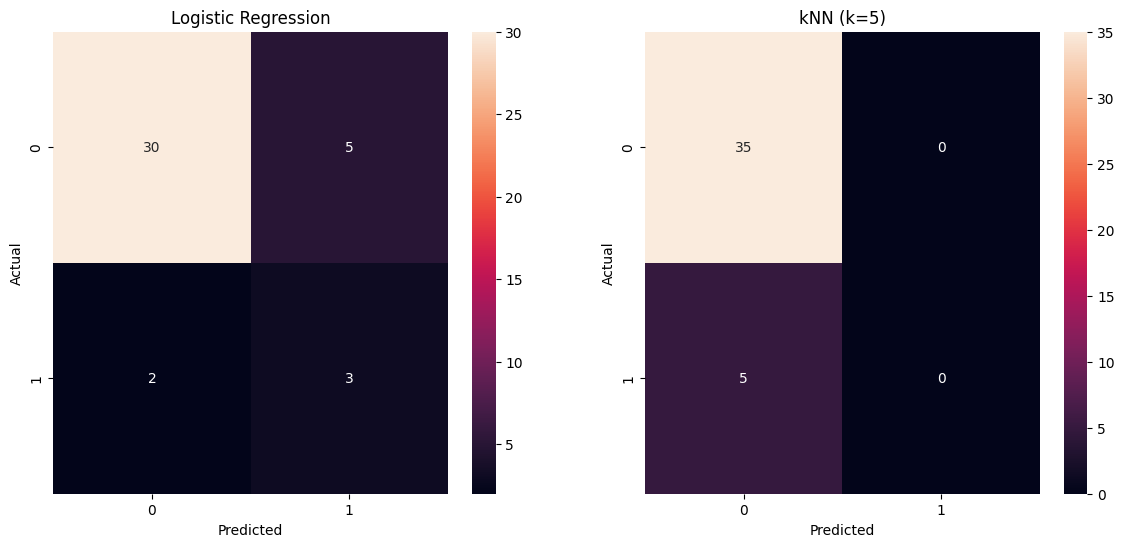

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', ax=axes[1])
axes[1].set_title("kNN (k=5)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()

In [12]:
test_results = X_test.copy()
test_results["actual"] = y_test
test_results["log_pred"] = y_pred_log
test_results["knn_pred"] = y_pred_knn
test_results["title"] = df.loc[X_test.index, "title"]

# Logistic regression misclassifications
misclassified = test_results[test_results["actual"] != test_results["log_pred"]]

print("Misclassified movies (Logistic Regression):")
mis_log = misclassified[["title", "actual", "log_pred"]].head(5)
mis_log

Misclassified movies (Logistic Regression):


,title,actual,log_pred
4,Avatar,0,1
14,Django Unchained,1,0
114,Catch Me If You Can,0,1
57,Coco,1,0
155,Aquaman,0,1


In [13]:
df.to_csv("tmdb_timeless_movies.csv", index=False)
test_results.to_csv("tmdb_test_predictions.csv", index=False)

print("Files saved:")
print("tmdb_timeless_movies.csv")
print("tmdb_test_predictions.csv")

Files saved:
tmdb_timeless_movies.csv
tmdb_test_predictions.csv
